In [1]:
!git clone https://github.com/mertiris-m/thesis.git
%cd thesis

Cloning into 'thesis'...
remote: Enumerating objects: 157844, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 157844 (delta 9), reused 37 (delta 8), pack-reused 157802 (from 1)
Receiving objects: 100% (157844/157844), 386.68 MiB | 24.86 MiB/s, done.
Resolving deltas: 100% (23623/23623), done.
Updating files: 100% (157760/157760), done.
/content/thesis


In [2]:
!pip install torch_geometric rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 59.8 MB/s eta 0:00:00


# QM9

## GCNConv & CINEConv model

### Imports and Setup

In [3]:
import os
from pathlib import Path
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import joblib
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error

root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
qm9_path = root / 'data' / 'QM9' / 'dsgdb9nsd.xyz'
qm9_edit_dir = root / 'data' / 'QM9_edit'
qm9_csv_path = qm9_edit_dir / 'QM9_edit.csv'
qm9_dataset_path = qm9_edit_dir / 'qm9_dataset.pt'
models_dir = root / 'models'
results_dir = root / 'results'

print(f"PyTorch version: {torch.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

os.chdir(root)

from src.models.gcn_baseline import GCN_baseline
from src.models.gine import GINE


PyTorch version: 2.6.0+cu124
Using device: cuda
----- Baseline GCN Model Architecture -----
GCN_baseline(
  (conv1): GCNConv(14, 128)
  (conv2): GCNConv(128, 128)
  (fc_block): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=3, bias=True)
  )
)

Model created successfully and ready to be used.
----- GINE Model Architecture -----
GINE(
  (conv1): GINEConv(nn=Sequential(
    (0): Linear(in_features=14, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  ))
  (conv2): GINEConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  ))
  (fc_block): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, o

### Constants

In [9]:
ROOT_DIR = root # Assumes running from project root
DATASET_PATH = qm9_dataset_path
SCALER_DIR = qm9_edit_dir
PROPERTY_NAMES = ['Dipole_moment', 'U', 'Cv']

# Training Hyperparameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 500 # Large since there will be early stopping
HIDDEN_DIM = 256
DROPOUT_RATE = 0.2
SPLIT_RATIOS = [0.8, 0.1, 0.1] # Train, Validation, Test

# Plotting Style
plt.style.use('seaborn-v0_8-paper')

print(f"Device: {DEVICE}")
print(f"Dataset Path: {DATASET_PATH}")

Device: cuda
Dataset Path: /content/thesis/data/QM9_edit/qm9_dataset.pt


### Data loading and Splitting

In [5]:
# Load Dataset
print("Dataset loading...")
full_dataset = torch.load(DATASET_PATH, weights_only=False)
print(f"Dataset loaded with {len(full_dataset)} total graphs.")

# Determine feature sizes from the first graph
first_graph = full_dataset[0]
num_node_features = first_graph.num_node_features
num_edge_features = first_graph.num_edge_features
num_properties = first_graph.y.shape[1]

# Split Train, Validation and Test sets
train_size = int(SPLIT_RATIOS[0] * len(full_dataset))
val_size = int(SPLIT_RATIOS[1] * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Dataset loading...
Dataset loaded with 133885 total graphs.
Train samples: 107108, Validation samples: 13388, Test samples: 13389


### Training and Evaluation Functions

In [10]:
def train(model, dataloader, optimizer, loss_fn, device):

    model.train()
    total_loss = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, data.y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs # loss.item() is the average loss for the batch * number of graphs on batch
        optimizer.step()
    return total_loss / len(dataloader.dataset) # the total average loss

@torch.no_grad()
def test(model, dataloader, loss_fn, device):

    model.eval()
    total_loss = 0
    for data in dataloader:
        data = data.to(device)
        outputs = model(data)
        loss = loss_fn(outputs, data.y)
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(dataloader.dataset) # the total average error

def run_training_with_early_stopping(model, model_name, train_loader, val_loader, epochs, lr, device, patience=15):
    """
    Runs the training process with early stopping.
    """

    if patience < 1:
            raise ValueError("Argument patience should be positive integer.")

    print(f"\n----- Training {model_name} with Early Stopping (Patience={patience}) -----")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val_loss = None
    patience_counter = 0 # Initialize patience counter

    # Keep history for plotting
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, epochs + 1):
        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        val_loss  = test(model, val_loader, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if epoch % 10 == 0 or epoch == 1:
             print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Val Error: {val_loss:.6f}")

        if best_val_loss is None or val_loss <= best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 # Reset counter on improvement
            # Save the best model
            os.makedirs('models', exist_ok=True)
            torch.save(model.state_dict(), f'models/{model_name}_best.pt')
        else:
            patience_counter += 1 # Increment counter if no improvement

        if patience_counter >= patience:
            print(f"--- Early stopping triggered at epoch {epoch} ---")
            break

    print(f"----- Finished training {model_name}. Best Val Error: {best_val_loss:.6f} -----")

    # Return the trained model and the history for plotting
    return model, history

### Training the baseline GCN

In [11]:
gcn_baseline_model = GCN_baseline(
    node_features=num_node_features,
    hidden_dim=HIDDEN_DIM,
    output_dim=num_properties,
    dropout_rate=DROPOUT_RATE
).to(DEVICE)

trained_gcn_model, gcn_history = run_training_with_early_stopping(
    gcn_baseline_model, "GCN Baseline", train_loader, val_loader, EPOCHS, LEARNING_RATE, DEVICE
)


----- Training GCN Baseline with Early Stopping (Patience=15) -----
Epoch 001 | Train Loss: 0.005947 | Val Error: 0.001537
Epoch 010 | Train Loss: 0.000620 | Val Error: 0.000512
Epoch 020 | Train Loss: 0.000526 | Val Error: 0.000429
Epoch 030 | Train Loss: 0.000503 | Val Error: 0.000408
Epoch 040 | Train Loss: 0.000488 | Val Error: 0.000414
Epoch 050 | Train Loss: 0.000479 | Val Error: 0.000430
Epoch 060 | Train Loss: 0.000473 | Val Error: 0.000401
Epoch 070 | Train Loss: 0.000468 | Val Error: 0.000409
Epoch 080 | Train Loss: 0.000469 | Val Error: 0.000407
Epoch 090 | Train Loss: 0.000465 | Val Error: 0.000406
Epoch 100 | Train Loss: 0.000462 | Val Error: 0.000394
--- Early stopping triggered at epoch 102 ---
----- Finished training GCN Baseline. Best Val Error: 0.000372 -----


### Training the GINE model

In [15]:
gine_model = GINE(
    node_features=num_node_features,
    edge_features=num_edge_features,
    hidden_dim=HIDDEN_DIM,
    output_dim=num_properties,
    dropout_rate=DROPOUT_RATE
).to(DEVICE)

trained_gine_model, gine_history = run_training_with_early_stopping(
    gine_model, "GINE", train_loader, val_loader, EPOCHS, LEARNING_RATE, DEVICE
)


----- Training GINE with Early Stopping (Patience=15) -----
Epoch 001 | Train Loss: 0.018521 | Val Error: 0.000963
Epoch 010 | Train Loss: 0.000526 | Val Error: 0.000447
Epoch 020 | Train Loss: 0.000433 | Val Error: 0.000368
Epoch 030 | Train Loss: 0.000404 | Val Error: 0.000359
Epoch 040 | Train Loss: 0.000393 | Val Error: 0.000366
Epoch 050 | Train Loss: 0.000388 | Val Error: 0.000341
Epoch 060 | Train Loss: 0.000379 | Val Error: 0.000345
Epoch 070 | Train Loss: 0.000378 | Val Error: 0.000330
Epoch 080 | Train Loss: 0.000370 | Val Error: 0.000322
Epoch 090 | Train Loss: 0.000368 | Val Error: 0.000344
--- Early stopping triggered at epoch 95 ---
----- Finished training GINE. Best Val Error: 0.000322 -----


### Evaluate and History plot function

In [13]:
# ----------- These were made with A.I. -----------

def evaluate_and_plot(model, model_name, loader, device, scalers, prop_names):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            preds = model(data)
            all_preds.append(preds.cpu().numpy())
            all_true.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_true = np.concatenate(all_true, axis=0)

    # --- Inverse transform to get results in original units ---
    unscaled_preds = np.zeros_like(all_preds)
    unscaled_true = np.zeros_like(all_true)

    print(f"\n----- Results for {model_name} -----")
    for i, name in enumerate(prop_names):
        scaler = scalers[name]
        # Reshape for scaler which expects 2D array
        unscaled_preds[:, i] = scaler.inverse_transform(all_preds[:, i].reshape(-1, 1)).flatten()
        unscaled_true[:, i] = scaler.inverse_transform(all_true[:, i].reshape(-1, 1)).flatten()

        mse = mean_squared_error(unscaled_true[:, i], unscaled_preds[:, i])
        print(f"  - {name} MSE: {mse:.4f}")

    # --- Plotting ---
    fig, axes = plt.subplots(1, len(prop_names), figsize=(18, 5))
    fig.suptitle(f'{model_name}: True vs. Predicted Values', fontsize=16)

    for i, (ax, name) in enumerate(zip(axes, prop_names)):
        ax.scatter(unscaled_true[:, i], unscaled_preds[:, i], alpha=0.3, s=10)

        # Add a y=x line for reference
        limits = [
            min(ax.get_xlim()[0], ax.get_ylim()[0]),
            max(ax.get_xlim()[1], ax.get_ylim()[1]),
        ]
        ax.plot(limits, limits, color='red', linestyle='--', label='Perfect Prediction')

        ax.set_xlabel(f"True {name}")
        ax.set_ylabel(f"Predicted {name}")
        ax.set_title(name)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def plot_training_history(history, model_name):
    """
    Plots the training and validation loss curves from a history dictionary.
    """
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    epochs = range(1, len(history['train_loss']) + 1)

    # Plot training and validation loss
    ax.plot(epochs, history['train_loss'], 'o-', label='Training Loss', alpha=0.8)
    ax.plot(epochs, history['val_loss'], 'o-', label='Validation Loss', alpha=0.8)

    # Find the epoch with the best validation loss for annotation
    best_val_epoch = np.argmin(history['val_loss']) + 1
    best_val_loss = np.min(history['val_loss'])

    # Add a vertical line and annotation for the best epoch
    ax.axvline(best_val_epoch, color='red', linestyle='--', lw=1, label=f'Best Epoch ({best_val_epoch})')
    ax.annotate(f'Best Val Loss: {best_val_loss:.4f}',
                xy=(best_val_epoch, best_val_loss),
                xytext=(best_val_epoch + 5, best_val_loss + 0.05 * best_val_loss), # Offset for readability
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1, alpha=0.7))

    # Formatting
    ax.set_title(f'{model_name}: Training and Validation Loss', fontsize=16)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (MSE)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

    # Ensure y-axis starts from a reasonable place if losses are small
    ax.set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()

### Run evaluate and plot

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



----- Results for GCN Baseline -----
  - Dipole_moment MSE: 0.7627
  - U MSE: 12.5051
  - Cv MSE: 0.3460


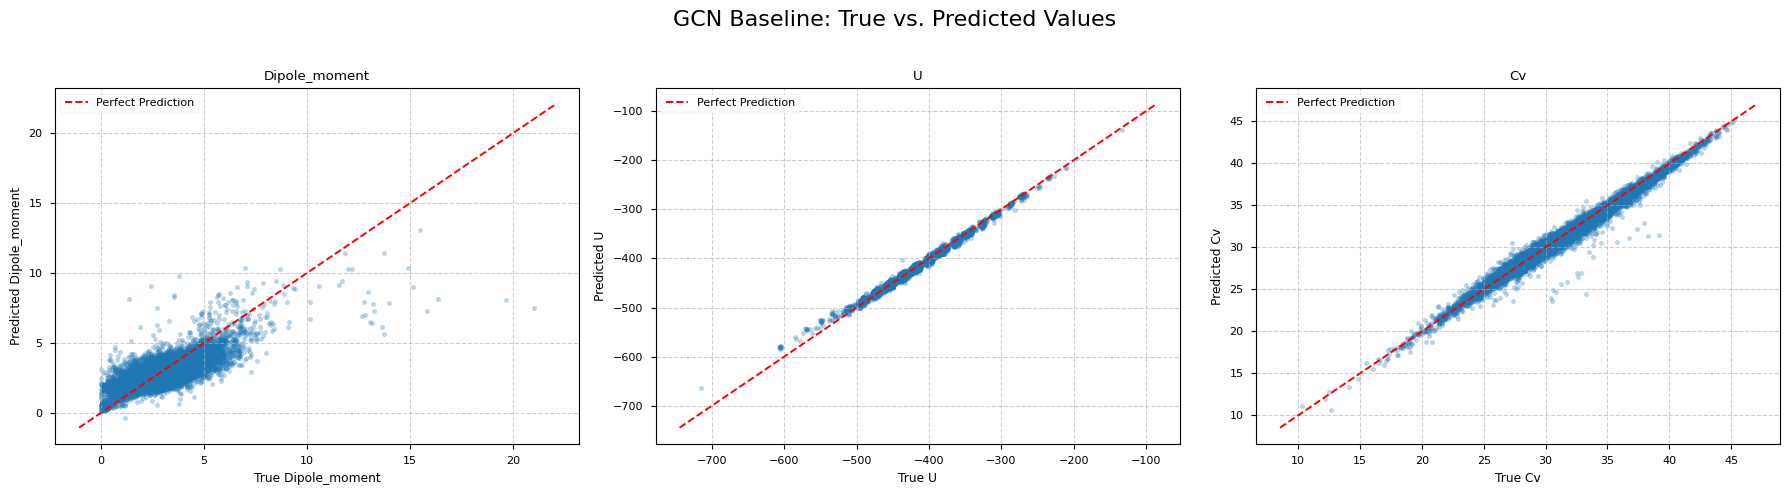


----- Results for GINE Model -----
  - Dipole_moment MSE: 0.7442
  - U MSE: 13.4912
  - Cv MSE: 0.3048


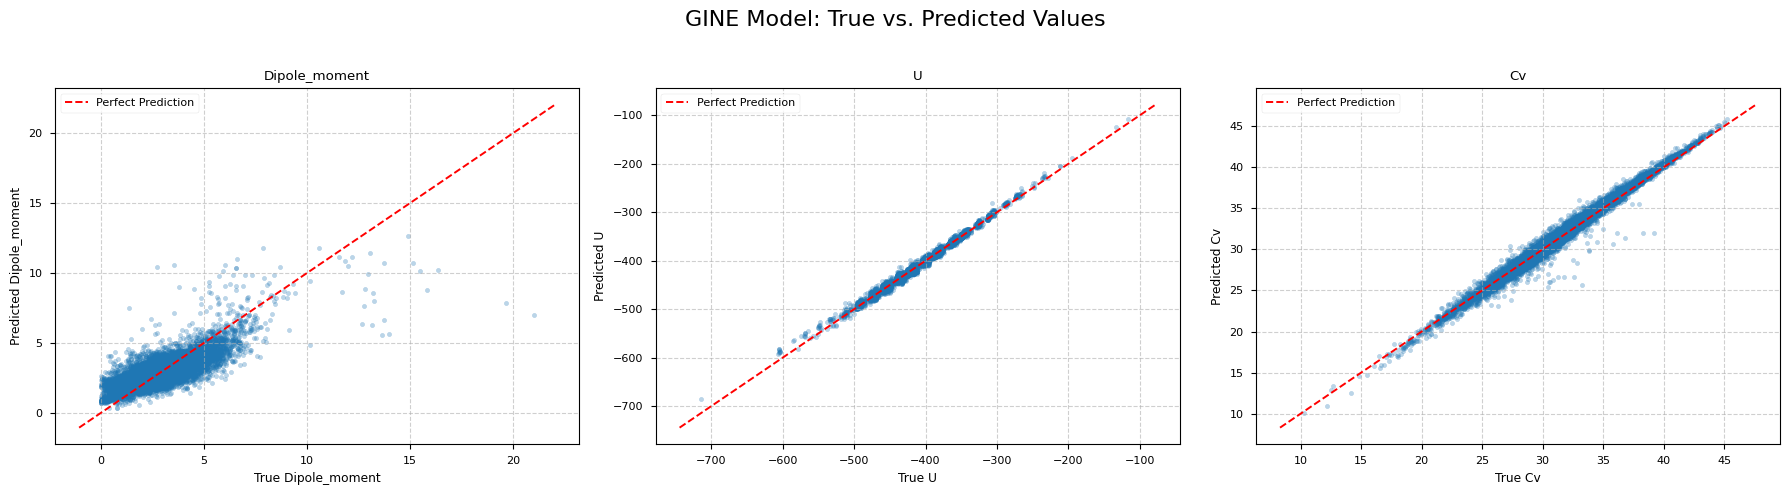

In [16]:
scalers = {}
for name in PROPERTY_NAMES:
    scaler_path = os.path.join(SCALER_DIR, f'{name}_QM9_scaler.pkl')
    scalers[name] = joblib.load(scaler_path)

# # Evaluate the GCN Baseline model
evaluate_and_plot(trained_gcn_model, "GCN Baseline", test_loader, DEVICE, scalers, PROPERTY_NAMES)

# Evaluate the GINE model
evaluate_and_plot(trained_gine_model, "GINE Model", test_loader, DEVICE, scalers, PROPERTY_NAMES)

### Run History plot

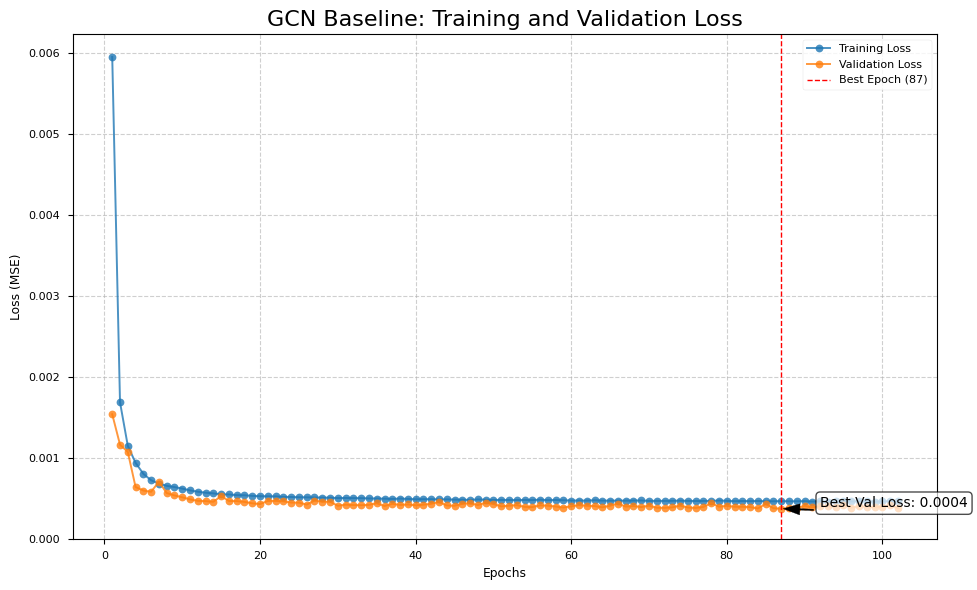

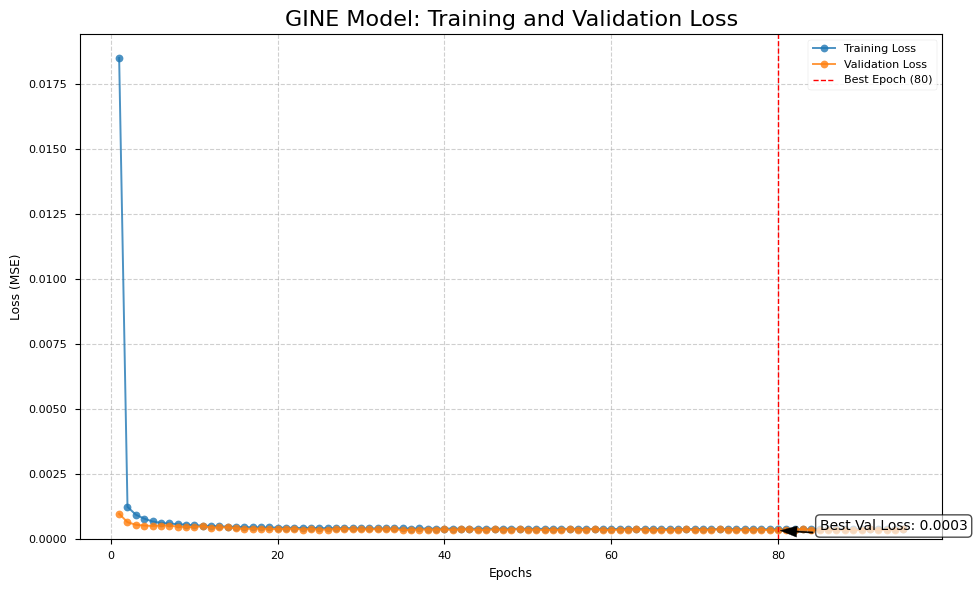

In [17]:
plot_training_history(gcn_history, "GCN Baseline")

plot_training_history(gine_history, "GINE Model")